In [29]:
from schema import df_sales,spark
from pyspark.sql.functions import when,col,udf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.types import StringType,FloatType
import seaborn as sns

In [11]:
def mult(quantity, price):
    return round(quantity*float(price.replace(',', '.')), 2)

multiply = udf(mult,FloatType())

def date_to_day(s):
    return datetime.strptime(s,"%d/%m/%Y").strftime('%A')

reg_sal = udf(lambda q : date_to_day(q), StringType())  

In [12]:
horaires_vente = df_sales.select(["Date","Time","TicketNumber","Quantity","UnitPrice"])\
                .withColumn("TimeInterval",\
                    when(df_sales.Time.rlike("07:[0-2][0-9]$"),"07:00 - 07:30")\
                    .when(df_sales.Time.rlike("07:[3-5][0-9]$"),"07:30 - 08:00")\
                    .when(df_sales.Time.rlike("08:[0-2][0-9]$"),"08:00 - 08:30")\
                    .when(df_sales.Time.rlike("08:[3-5][0-9]$"),"08:30 - 09:00")\
                    .when(df_sales.Time.rlike("09:[0-2][0-9]$"),"09:00 - 09:30")\
                    .when(df_sales.Time.rlike("09:[3-5][0-9]$"),"09:30 - 10:00")\
                    .when(df_sales.Time.rlike("10:[0-2][0-9]$"),"10:00 - 10:30")\
                    .when(df_sales.Time.rlike("10:[3-5][0-9]$"),"10:30 - 11:00")\
                    .when(df_sales.Time.rlike("11:[0-2][0-9]$"),"11:00 - 11:30")\
                    .when(df_sales.Time.rlike("11:[3-5][0-9]$"),"11:30 - 12:00")\
                    .when(df_sales.Time.rlike("12:[0-2][0-9]$"),"12:00 - 12:30")\
                    .when(df_sales.Time.rlike("12:[3-5][0-9]$"),"12:30 - 13:00")\
                    .when(df_sales.Time.rlike("13:[0-2][0-9]$"),"13:00 - 13:30")\
                    .when(df_sales.Time.rlike("13:[3-5][0-9]$"),"13:30 - 14:00")\
                    .when(df_sales.Time.rlike("14:[0-2][0-9]$"),"14:00 - 14:30")\
                    .when(df_sales.Time.rlike("14:[3-5][0-9]$"),"14:30 - 15:00")\
                    .when(df_sales.Time.rlike("15:[0-2][0-9]$"),"15:00 - 15:30")\
                    .when(df_sales.Time.rlike("15:[3-5][0-9]$"),"15:30 - 16:00")\
                    .when(df_sales.Time.rlike("16:[0-2][0-9]$"),"16:00 - 16:30")\
                    .when(df_sales.Time.rlike("16:[3-5][0-9]$"),"16:30 - 17:00")\
                    .when(df_sales.Time.rlike("17:[0-2][0-9]$"),"17:00 - 17:30")\
                    .when(df_sales.Time.rlike("17:[3-5][0-9]$"),"17:30 - 18:00")\
                    .when(df_sales.Time.rlike("18:[0-2][0-9]$"),"18:00 - 18:30")\
                    .when(df_sales.Time.rlike("18:[3-5][0-9]$"),"18:30 - 19:00")\
                    .when(df_sales.Time.rlike("19:[0-2][0-9]$"),"19:00 - 19:30")\
                    .when(df_sales.Time.rlike("19:[3-5][0-9]$"),"19:30 - 20:00")\
                    .when(df_sales.Time.rlike("20:[0-2][0-9]$"),"20:00 - 20:30"))\
                .withColumn("Day",reg_sal(col("Date")))


In [15]:
#Horaires semaine
horaires_lundi = horaires_vente.filter(horaires_vente["Day"]=="Monday")
horaires_mardi = horaires_vente.filter(horaires_vente["Day"]=="Tuesday")
horaires_mercredi = horaires_vente.filter(horaires_vente["Day"]=="Wednesay")
horaires_jeudi = horaires_vente.filter(horaires_vente["Day"]=="Thursday")
horaires_vendredi = horaires_vente.filter(horaires_vente["Day"]=="Friday")
horaires_samedi = horaires_vente.filter(horaires_vente["Day"]=="Saturday")
horaires_dimanche = horaires_vente.filter(horaires_vente["Day"]=="Sunday")

In [89]:
ca_horaires__par_jour = horaires_vente.withColumn("Subtotal",multiply("Quantity","UnitPrice")).groupBy("Day","TimeInterval").sum("Subtotal").sort(col("TimeInterval")).withColumnRenamed("sum(Subtotal)", "sum")

### Graphique du CA par jour et par tranche horaires 

In [95]:
ca_jour_horaire_pd =ca_horaires__par_jour.toPandas()


In [83]:
def sum_for_day_and_time(day, time):
    try:
        return ca_jour_horaire_pd.loc[(ca_jour_horaire_pd.Day==day)&(ca_jour_horaire_pd.TimeInterval == time)]['sum'].values[0]
    except:
        return 0

In [84]:
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
times = list(ca_jour_horaire_pd.TimeInterval.unique())

In [85]:
df_plot = pd.DataFrame({'time': times})
for day in DAYS:
    df_plot[day] = [sum_for_day_and_time(day, time) for time in times]

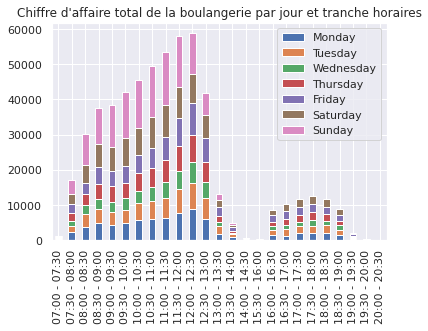

In [87]:
sns.set()
df_plot.plot(kind='bar', stacked=True)
plt.xticks(ticks =range(25),labels = times)
plt.title("Chiffre d'affaire total de la boulangerie par jour et tranche horaires")
plt.show()


### Graphique du CA moyen par jour et par tranche horaires 

+---------+-----+
|      Day|count|
+---------+-----+
|Wednesday|   62|
|  Tuesday|   89|
|   Friday|   91|
| Thursday|   89|
| Saturday|   90|
|   Monday|   88|
|   Sunday|   91|
+---------+-----+



In [127]:
nb_jour = horaires_vente.dropDuplicates(["Date"]).groupBy("Day").count().withColumnRenamed("count()","number_days")

nb_jour_pd = nb_jour.toPandas()

def mean_sum_for_day_and_time(day, time):
    try:
        nb = nb_jour_pd.loc[nb_jour_pd.Day == day].values[0][1]
        return ca_jour_horaire_pd.loc[(ca_jour_horaire_pd.Day==day)&(ca_jour_horaire_pd.TimeInterval == time)]['sum'].values[0]/nb
    except:
        return 0


In [120]:
nb_jour.show()


+---------+-----+
|      Day|count|
+---------+-----+
|Wednesday|21470|
|  Tuesday|29855|
|   Friday|31709|
| Thursday|30498|
| Saturday|38051|
|   Monday|32317|
|   Sunday|50073|
+---------+-----+



In [128]:
df_plot_2 = pd.DataFrame({'time': times})
for day in DAYS:
    df_plot_2[day] = [mean_sum_for_day_and_time(day, time) for time in times]

In [129]:
df_plot_2

,time,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,07:00 - 07:30,2.172159,1.246067,1.550000,1.314045,1.977473,1.913889,1.998352
1,07:30 - 08:00,25.693750,19.131461,24.049194,23.715730,29.002198,32.214444,42.439560
2,08:00 - 08:30,42.959091,40.449438,41.051613,34.906742,36.257143,54.322222,97.601649
3,08:30 - 09:00,55.265909,45.028652,46.808871,47.119101,54.218132,72.383889,113.152747
4,09:00 - 09:30,50.046023,40.814045,47.239516,50.250562,47.397802,74.001111,132.787363
5,09:30 - 10:00,54.114773,42.335955,54.287097,50.185955,50.815385,88.252778,144.503846
6,10:00 - 10:30,65.184659,53.435393,57.224194,57.167416,56.652198,84.552222,150.525824
7,10:30 - 11:00,69.264773,55.436517,64.785484,62.615955,61.384066,96.646111,160.736594
8,11:00 - 11:30,69.697159,65.476966,72.534677,72.174045,70.674176,101.781111,166.508791
9,11:30 - 12:00,87.983523,75.857303,81.399194,82.168764,86.480769,97.431111,158.684616


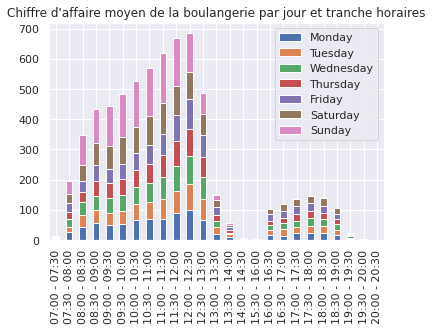

In [130]:
sns.set()
df_plot_2.plot(kind='bar', stacked=True)
plt.xticks(ticks =range(25),labels = times)
plt.title("Chiffre d'affaire moyen de la boulangerie par jour et tranche horaires")
plt.show()
